In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders
from lib.models import ANN, LoRA_ANN
from lib.train import train_ANN
from lib.test import test
from lib.save import save

import os
import numpy as np
import torch

In [2]:
train_vanilla = True

In [3]:
device = get_device()

In [4]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"
model_path = path + "\\ANN_LoRA\\"

Playable HPs :
- LoRA rank
- trade-off

Other HPs :
- batch_size

In [5]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 500
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

## Reproducibility

In [6]:
random_seed = 88

## Get MNIST loaders

In [7]:
# We train on MNIST 0 to 4, then each new task is being able to classify a new digit (5 to 9)

In [8]:
train_loaders_list, val_loaders_list, test_loaders_list = get_MNIST_loaders(data_path, batch_size, random_seed, 0.7)

## Train vanilla ANN on digits 0 to 4

In [9]:
if train_vanilla :
    train_loader = train_loaders_list[0]
    test_loader = test_loaders_list[0]

In [10]:
if train_vanilla :
    lr = 1e-3
    num_epochs = 2

In [11]:
if train_vanilla :
    model = ANN(num_inputs, num_hidden, num_outputs)

In [12]:
if train_vanilla :
    train_ANN(model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.07s/it]


In [13]:
if train_vanilla :
    test(model, test_loader, batch_size, device)

## Save vanilla ANN

In [14]:
if train_vanilla :
    vanilla_path = model_path+"ICL5_state_dict_digits_0_to_4.pth"

In [15]:
if train_vanilla :
    save(vanilla_path, model)

## CL on digits 5 to 9 with LoRA

In [16]:
import optuna
from functools import partial
import matplotlib.pyplot as plt

In [17]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 32)
    alpha = trial.suggest_float("alpha", 0.5, 3)
    
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size)

    return lora_ann_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_ann_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 1e-5, 5e-4)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size = params[-1]
    
    train_loader = train_loaders_list[task_number+1]
    #val_loader = val_loaders[task_number]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score

In [18]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size).to(device)

    # Train
    train_loader = train_loaders_list[i+1]
    #val_loader = val_loaders[i]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_ann_model.model.fc1.weight + alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
    lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_ann_model.model.fc2.weight + alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
    lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    save(model_path, lora_ann_model.model)
    
    return test_accs

In [19]:
# Compute scores of the model trained on the first task
model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

lora_rank = 16 # The value of this parameters has no influence
alpha = 1.8 # The value of this parameter has no influence

lora_ann_model = LoRA_ANN(lora_rank,
                          alpha, 
                          model_path, 
                          num_inputs, 
                          num_hidden, 
                          num_outputs, 
                          batch_size).to(device)

# Test the model trained on digits 0 to 4
test_accs = np.zeros(10)
for j in range(5) :
    test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
    test_accs[j] = test_acc
        
# Initialize variable to store the best HPs and the scores
best_params = []
scores = [test_acc]
test_accs_matrix = [test_accs]
mean_test_accs_through_past_tasks = [test_acc]

for i in range(5,10) :
    print(f"Learning Task {i+1}")
    # Perform HPO
    storage = optuna.storages.InMemoryStorage()
    study = optuna.create_study(storage=storage,
                                study_name="The Search",
                                #sampler=
                                direction = "maximize")
    
    params = num_inputs, num_hidden, num_outputs, batch_size
    partial_objective = partial(objective, i, model_path, params, device)
    study.optimize(partial_objective,
                   n_trials=6,
                   timeout=3600)

    # Retrain and save a model with the best params
    best_trial = study.best_trial
    best_params.append(best_trial.params)
    test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    
    # Compute and store scores
    mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
    score = mu - sigma
    
    scores.append(score)
    test_accs_matrix.append(test_accs)
    mean_test_accs_through_past_tasks.append(mu)

[I 2024-05-27 10:10:39,801] A new study created in memory with name: The Search


Learning Task 6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]
[I 2024-05-27 10:10:42,836] Trial 0 finished with value: 33.86504144789723 and parameters: {'lora_rank': 25, 'alpha': 2.604689111987976, 'lr': 0.00026096764277138893, 'num_epochs': 1}. Best is trial 0 with value: 33.86504144789723.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]
[I 2024-05-27 10:10:47,791] Trial 1 finished with value: 45.465881987646654 and parameters: {'lora_rank': 17, 'alpha': 2.2822737842017125, 'lr': 6.365584664884801e-05, 'num_epochs': 2}. Best is trial 1 with value: 45.465881987646654.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]
[I 2024-05-27 10:10:53,926] Trial 2 finished with value: -12.696691350243771 and parameters: {'lora_rank': 22, 'alpha': 2.8187570849386967, 'lr': 0.00018456918149097932, 'num

Learning Task 7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]
[I 2024-05-27 10:11:16,545] Trial 0 finished with value: 33.908851964972946 and parameters: {'lora_rank': 15, 'alpha': 1.8761177340751087, 'lr': 0.00022462966074856053, 'num_epochs': 1}. Best is trial 0 with value: 33.908851964972946.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/it]
[I 2024-05-27 10:11:21,117] Trial 1 finished with value: 41.43354227558555 and parameters: {'lora_rank': 25, 'alpha': 2.941842030851065, 'lr': 9.657967408724234e-05, 'num_epochs': 2}. Best is trial 1 with value: 41.43354227558555.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]
[I 2024-05-27 10:11:27,761] Trial 2 finished with value: -16.926550755091966 and parameters: {'lora_rank': 30, 'alpha': 2.4111305455939043, 'lr': 0.0003456552892080452, 'num_

Learning Task 8


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]
[I 2024-05-27 10:11:55,124] Trial 0 finished with value: -15.458377590945403 and parameters: {'lora_rank': 29, 'alpha': 1.688285682107133, 'lr': 0.0004417165395863322, 'num_epochs': 2}. Best is trial 0 with value: -15.458377590945403.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]
[I 2024-05-27 10:11:58,775] Trial 1 finished with value: 26.446702877588322 and parameters: {'lora_rank': 24, 'alpha': 1.2049084257010843, 'lr': 0.00014992507648248828, 'num_epochs': 1}. Best is trial 1 with value: 26.446702877588322.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]
[I 2024-05-27 10:12:04,080] Trial 2 finished with value: -16.7494336962092 and parameters: {'lora_rank': 27, 'alpha': 1.903475879032148, 'lr': 0.0004350934144678709, 'num

Learning Task 9


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.70s/it]
[I 2024-05-27 10:12:41,779] Trial 0 finished with value: -15.060028426529868 and parameters: {'lora_rank': 16, 'alpha': 2.626390212397623, 'lr': 0.0002152765099241665, 'num_epochs': 4}. Best is trial 0 with value: -15.060028426529868.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]
[I 2024-05-27 10:12:47,522] Trial 1 finished with value: 17.78461478100727 and parameters: {'lora_rank': 13, 'alpha': 0.8077848015158097, 'lr': 0.0001628320418588509, 'num_epochs': 2}. Best is trial 1 with value: 17.78461478100727.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/it]
[I 2024-05-27 10:12:56,592] Trial 2 finished with value: -3.1766577040109425 and parameters: {'lora_rank': 21, 'alpha': 0.540376210291271, 'lr': 0.00019638557204079975, 'num

Learning Task 10


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]
[I 2024-05-27 10:13:27,880] Trial 0 finished with value: 19.92108377931543 and parameters: {'lora_rank': 23, 'alpha': 1.953146851717264, 'lr': 3.349963874089038e-05, 'num_epochs': 3}. Best is trial 0 with value: 19.92108377931543.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]
[I 2024-05-27 10:13:35,111] Trial 1 finished with value: -6.194945074694061 and parameters: {'lora_rank': 24, 'alpha': 1.9195222645131889, 'lr': 0.00013878306876724902, 'num_epochs': 3}. Best is trial 0 with value: 19.92108377931543.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.27s/it]
[I 2024-05-27 10:13:43,950] Trial 2 finished with value: -18.377740292617347 and parameters: {'lora_rank': 27, 'alpha': 1.0618746314148302, 'lr': 0.0004615984913073386, 'num_e

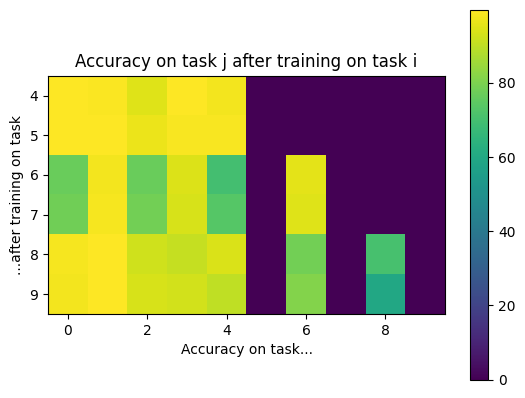

In [20]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

In [21]:
np.array(test_accs_matrix).sum(1)

array([491.46553571, 492.87482143, 511.54142857, 517.05321429,
       624.16589286, 614.82339286])

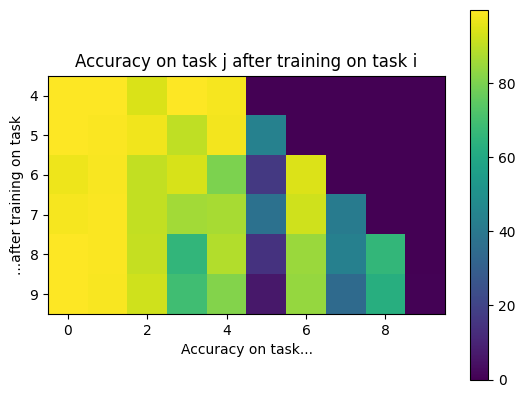

In [20]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

In [21]:
np.array(test_accs_matrix).sum(1)

array([491.43910714, 528.69071429, 571.73166667, 632.30047619,
       652.65708333, 629.64375   ])

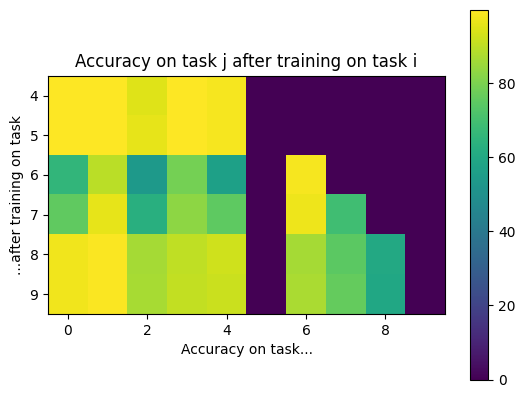

In [20]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

In [21]:
np.array(test_accs_matrix).sum(1)

array([492.12160714, 493.2675    , 442.85732143, 558.58125   ,
       687.28589286, 689.11857143])

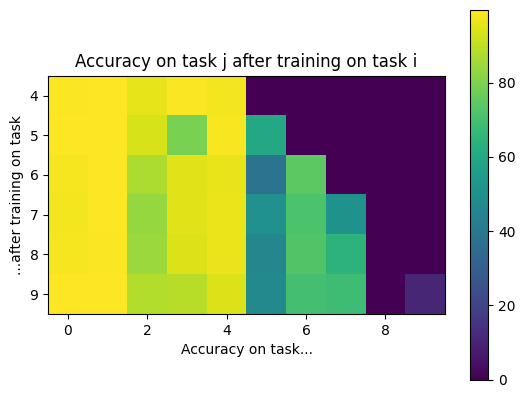

In [20]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

In [22]:
np.array(test_accs_matrix).sum(1)

array([491.09196429, 530.7960119 , 589.08869048, 645.28660714,
       656.39154762, 666.50196429])

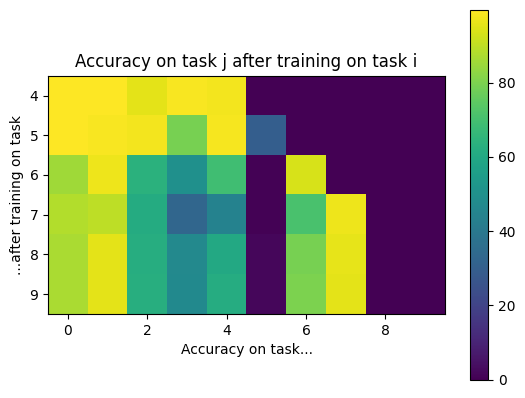

In [22]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

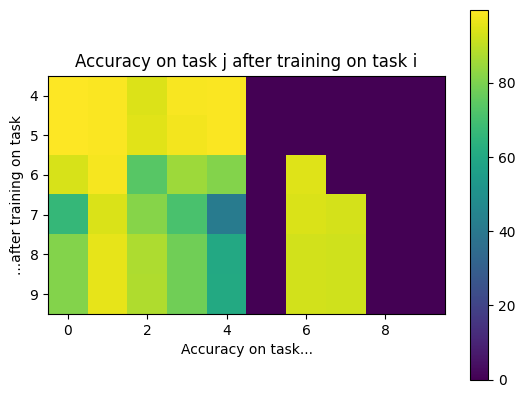

In [20]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

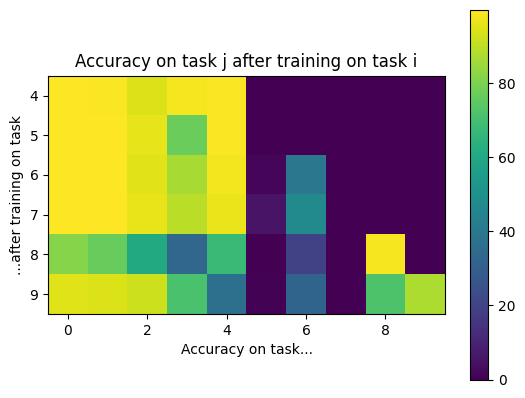

In [31]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()